In [208]:
import pandas as pd
import numpy as np
import cv2
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet
from sklearn.preprocessing import LabelEncoder

In [209]:
train_filepath = './train/'
test_filepath = './test/'

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

train_df['filepath'] = filepath + train_df['image']
test_df['image_path'] = './test/' + test_df['image']

In [210]:
def prepare_label(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values).reshape(len(values), 1)
    return integer_encoded, label_encoder

target, label_encoder = prepare_label(train_df['label'])

In [211]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((224, 224))
])

In [212]:
from PIL import Image
class Img_Dataset(Dataset):
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img = self.transform(img)
        
        return img

In [213]:
trainset = torchvision.datasets.ImageFolder('./train/', transform = transforms)
testset = Img_Dataset(test_df['image_path'].values.tolist(), transform = transforms)

trainloader = DataLoader(trainset, batch_size = 128, shuffle = True)
testloader = DataLoader(testset, batch_size = 128)

In [214]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet18(pretrained = True)
model.fc = nn.Linear(512, 6)

crterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
model = model.to(device)

In [215]:
import gc
gc.collect()

22533

In [216]:
losses = []
for ep in range(1, 41):
    running_loss = 0.0
    for data in trainloader:
        image, labels = data[0].to(device), data[1].to(device)
        outputs = model(image)
        optimizer.zero_grad()
        loss = crterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses.append(running_loss / len(trainloader))
    print('Epoch : [%d] loss : %.3f' % (ep, running_loss / len(trainloader)))

Epoch : [1] loss : 0.492
Epoch : [2] loss : 0.290
Epoch : [3] loss : 0.242
Epoch : [4] loss : 0.204
Epoch : [5] loss : 0.152
Epoch : [6] loss : 0.125
Epoch : [7] loss : 0.093
Epoch : [8] loss : 0.084
Epoch : [9] loss : 0.075
Epoch : [10] loss : 0.052
Epoch : [11] loss : 0.033
Epoch : [12] loss : 0.059
Epoch : [13] loss : 0.054
Epoch : [14] loss : 0.045
Epoch : [15] loss : 0.031
Epoch : [16] loss : 0.027
Epoch : [17] loss : 0.026
Epoch : [18] loss : 0.033
Epoch : [19] loss : 0.033
Epoch : [20] loss : 0.030
Epoch : [21] loss : 0.037
Epoch : [22] loss : 0.029
Epoch : [23] loss : 0.024
Epoch : [24] loss : 0.020
Epoch : [25] loss : 0.010
Epoch : [26] loss : 0.026
Epoch : [27] loss : 0.045
Epoch : [28] loss : 0.025
Epoch : [29] loss : 0.011
Epoch : [30] loss : 0.004
Epoch : [31] loss : 0.007
Epoch : [32] loss : 0.007
Epoch : [33] loss : 0.027
Epoch : [34] loss : 0.052
Epoch : [35] loss : 0.030
Epoch : [36] loss : 0.010
Epoch : [37] loss : 0.017
Epoch : [38] loss : 0.021
Epoch : [39] loss : 0

In [219]:
correct = 0
total = 0
predicted = []
with torch.no_grad():
    model.eval()
    for data in testloader:
        outputs = model(data.to(device))
        _, predict = torch.max(outputs, 1)
        predicted += predict.cpu()
        
array = label_encoder.inverse_transform(predicted)
array.reshape(len(array), 1)

array([['forest'],
       ['buildings'],
       ['forest'],
       ...,
       ['street'],
       ['forest'],
       ['sea']], dtype=object)

In [221]:
# array = predicted.cpu()
submission = pd.DataFrame({
    "image" : test_df['image'],
    'label' : array
})

submission.to_csv('fdsf1.csv', index = False)

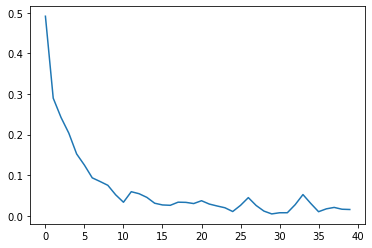

In [222]:
plt.plot(losses)